# Mixture Model 40

In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using BenchmarkTools
using DSP

In [2]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BenchmarkTools

In [3]:
using BAT 

# High `p` Population: 

In [4]:
conv_mat = load("../../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
) 

images = load("../../data/experiment/dataset_2/m2/images-satur.jld2");
event_number = 2

# Large Charge: Ev_2_2 = 2, Ev_2_1 = 311, Ev_2_3 = 440

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);


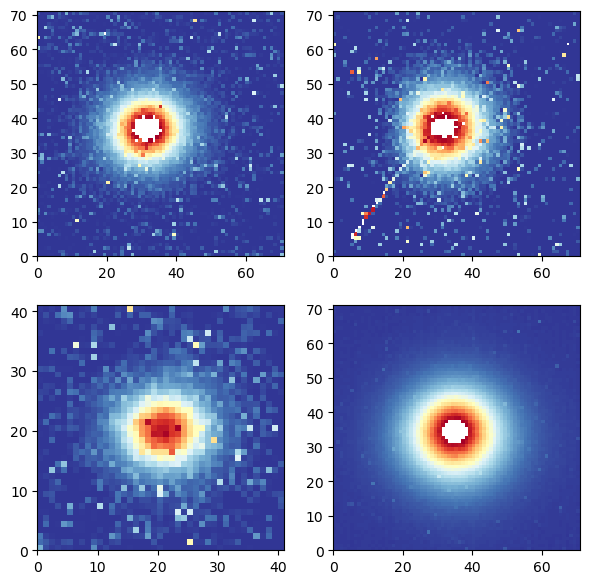

PyObject <matplotlib.collections.QuadMesh object at 0x7ff5d1b76d00>

In [5]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

In [6]:
# include("../src/likelihood.jl")
include("../../src/utill.jl")

corner_plots (generic function with 1 method)

In [7]:
function likelihood_cam4(
        params::NamedTuple, 
        image::Array{F,2},
        population::AbstractFloat,
        cam_ind::Integer;
        n_threads::Integer = Threads.nthreads()
    ) where {F <: AbstractFloat}
   

    VT = eltype(params.tr_size)
    tot_loglik::Array{VT} = zeros(VT, n_threads)    
    light_coefficient::VT = params.cam4_light_amp * 10^5
    
    δ_x::VT = params.cam4_psx * 10^-3
    δ_y::VT = params.cam4_psy * 10^-3
    
    @inbounds μ_x::VT  = params.algmx[cam_ind] * δ_x
    @inbounds μ_y::VT  = params.algmy[cam_ind] * δ_y
    
    @inbounds σ_x_1::VT = sqrt.(params.tr_size[1]^2 + 10^-4*params.ang_spr[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    @inbounds σ_y_1::VT = sqrt.(params.tr_size[2]^2 + 10^-4*params.ang_spr[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    
    σ_x_1_res::VT = sqrt(σ_x_1^2 + (params.cam4_resx*δ_x)^2)
    σ_y_1_res::VT = sqrt(σ_y_1^2 + (params.cam4_resy*δ_y)^2) 
    
    @inbounds σ_x_2::VT = sqrt.(params.tr_size_2[1]^2 + 10^-4*params.ang_spr_2[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    @inbounds σ_y_2::VT = sqrt.(params.tr_size_2[2]^2 + 10^-4*params.ang_spr_2[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    
    σ_x_2_res::VT = sqrt(σ_x_2^2 + (params.cam4_resx*δ_x)^2)
    σ_y_2_res::VT = sqrt(σ_y_2^2 + (params.cam4_resy*δ_y)^2) 
    
#     dist_x = MixtureModel(Normal[Normal(μ_x, σ_x_1_res), Normal(μ_x, σ_x_2_res)], [params.mixt_pow, 1-params.mixt_pow])
#     dist_y = MixtureModel(Normal[Normal(μ_y, σ_y_1_res), Normal(μ_y, σ_y_2_res)], [params.mixt_pow, 1-params.mixt_pow])
    
    dist_1_x = Normal(μ_x, σ_x_1_res)
    dist_1_y = Normal(μ_y, σ_y_1_res)
    
    dist_2_x = Normal(μ_x, σ_x_2_res)
    dist_2_y = Normal(μ_y, σ_y_2_res)
    
    Threads.@threads for t in eachindex(tot_loglik)
        
        cum_log_lik = zero(Float64) 
        
        @inbounds for pix_ind in CartesianIndices(image)[t:n_threads:length(image)] 
            @inbounds if !isnan(image[pix_ind])
                
                @inbounds x_edge = pix_ind.I[1] * δ_x
                @inbounds y_edge = pix_ind.I[2] * δ_y

#                 pix_prediction = cdf(dist_x, x_edge) - cdf(dist_x, x_edge - δ_x)
#                 pix_prediction *= cdf(dist_y, y_edge) - cdf(dist_y, y_edge - δ_y)
                
                right_tmp, left_tmp = pdf(dist_1_x, x_edge), pdf(dist_1_x, x_edge - δ_x)
                pix_prediction_1 = (left_tmp + 0.5*(right_tmp - left_tmp))*δ_x
                right_tmp, left_tmp = pdf(dist_1_y, y_edge), pdf(dist_1_y, y_edge - δ_y)
                pix_prediction_1 *= (left_tmp + 0.5*(right_tmp - left_tmp))*δ_y
                
                right_tmp, left_tmp = pdf(dist_2_x, x_edge), pdf(dist_2_x, x_edge - δ_x)
                pix_prediction_2 = (left_tmp + 0.5*(right_tmp - left_tmp))*δ_x
                right_tmp, left_tmp = pdf(dist_2_y, y_edge), pdf(dist_2_y, y_edge - δ_y)
                pix_prediction_2 *= (left_tmp + 0.5*(right_tmp - left_tmp))*δ_y
                
                pix_prediction = params.mixt_pow*pix_prediction_1 + (1-params.mixt_pow)*pix_prediction_2
                pix_prediction = pix_prediction*light_coefficient + params.cam4_ped
                
#                 @inbounds cum_log_lik += logpdf(truncated(Normal(pix_prediction, params.cam4_light_fluct*sqrt(pix_prediction)), 0.0, 4096.0), image[pix_ind]) # leads to -Inf
                @inbounds cum_log_lik += logpdf(Normal(pix_prediction, params.cam4_light_fluct*sqrt(pix_prediction)), image[pix_ind]) # significantly speeds up auto diff
                
            end
        end
        
        @inbounds tot_loglik[t] = cum_log_lik
    end
    return sum(tot_loglik)
end


function likelihood_cam13(
        params::NamedTuple, 
        image::Array{F,2},
        population::AbstractFloat,
        cv_matrix::Array{C,2},
        cv_func::Function, 
        cam_ind::Integer;
        n_threads::Integer = Threads.nthreads()
    ) where {F <: AbstractFloat, C <: AbstractFloat}
    
    VT = eltype(params.tr_size)
    tot_loglik::Array{VT} = zeros(VT, n_threads)    
    
    light_coefficient::VT = params.light_amp[cam_ind] * 10^5
    
    δ_x::VT = params.psx[cam_ind] * 10^-3
    δ_y::VT = params.psy[cam_ind] * 10^-3
    
    @inbounds μ_x::VT  = params.algmx[cam_ind] * δ_x
    @inbounds μ_y::VT  = params.algmy[cam_ind] * δ_y
    
    @inbounds σ_x_1::VT = sqrt.(params.tr_size[1]^2 + 10^-4*params.ang_spr[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    @inbounds σ_y_1::VT = sqrt.(params.tr_size[2]^2 + 10^-4*params.ang_spr[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    
    σ_x_1_res::VT = sqrt(σ_x_1^2 + (params.resx[cam_ind]*δ_x)^2)
    σ_y_1_res::VT = sqrt(σ_y_1^2 + (params.resy[cam_ind]*δ_y)^2) 
    
    @inbounds σ_x_2::VT = sqrt.(params.tr_size_2[1]^2 + 10^-4*params.ang_spr_2[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    @inbounds σ_y_2::VT = sqrt.(params.tr_size_2[2]^2 + 10^-4*params.ang_spr_2[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    
    σ_x_2_res::VT = sqrt(σ_x_2^2 + (params.resx[cam_ind]*δ_x)^2)
    σ_y_2_res::VT = sqrt(σ_y_2^2 + (params.resy[cam_ind]*δ_y)^2) 
    
#     dist_x = MixtureModel(Normal[Normal(μ_x, σ_x_1_res), Normal(μ_x, σ_x_2_res)], [params.mixt_pow, 1-params.mixt_pow])
#     dist_y = MixtureModel(Normal[Normal(μ_y, σ_y_1_res), Normal(μ_y, σ_y_2_res)], [params.mixt_pow, 1-params.mixt_pow])
    
    dist_1_x = Normal(μ_x, σ_x_1_res)
    dist_1_y = Normal(μ_y, σ_y_1_res)
    
    dist_2_x = Normal(μ_x, σ_x_2_res)
    dist_2_y = Normal(μ_y, σ_y_2_res)
    
    max_pred_amp = size(cv_matrix)[2]-1
    
    Threads.@threads for t in eachindex(tot_loglik)
        
        cum_log_lik = zero(Float64)
        
        @inbounds for pix_ind in CartesianIndices(image)[t:n_threads:length(image)] 
            @inbounds if !isnan(image[pix_ind])
                
                @inbounds x_edge = pix_ind.I[1] * δ_x
                @inbounds y_edge = pix_ind.I[2] * δ_y

#                 pix_prediction = cdf(dist_x, x_edge) - cdf(dist_x, x_edge - δ_x)
#                 pix_prediction *= cdf(dist_y, y_edge) - cdf(dist_y, y_edge - δ_y)
                
                right_tmp, left_tmp = pdf(dist_1_x, x_edge), pdf(dist_1_x, x_edge - δ_x)
                pix_prediction_1 = (left_tmp + 0.5*(right_tmp - left_tmp))*δ_x
                right_tmp, left_tmp = pdf(dist_1_y, y_edge), pdf(dist_1_y, y_edge - δ_y)
                pix_prediction_1 *= (left_tmp + 0.5*(right_tmp - left_tmp))*δ_y
                
                right_tmp, left_tmp = pdf(dist_2_x, x_edge), pdf(dist_2_x, x_edge - δ_x)
                pix_prediction_2 = (left_tmp + 0.5*(right_tmp - left_tmp))*δ_x
                right_tmp, left_tmp = pdf(dist_2_y, y_edge), pdf(dist_2_y, y_edge - δ_y)
                pix_prediction_2 *= (left_tmp + 0.5*(right_tmp - left_tmp))*δ_y

                pix_prediction = params.mixt_pow*pix_prediction_1 + (1-params.mixt_pow)*pix_prediction_2
                pix_prediction = pix_prediction*light_coefficient

                if pix_prediction > max_pred_amp - 1
                    pix_prediction -= pix_prediction - (max_pred_amp - 1)
                end
                
                @inbounds cum_log_lik += cv_func(cv_matrix, image[pix_ind], pix_prediction)
                
            end
        end
        tot_loglik[t] = cum_log_lik
        
    end

    return sum(tot_loglik)
end

function conv_tabl_discrete(cv_matrix::Array{F,2}, observed::Real, expected::Real) where {F<:AbstractFloat}  
    return cv_matrix[convert(Integer, observed+1), round(Integer, expected+1)]     
end

conv_tabl_discrete (generic function with 1 method)

In [8]:
"""
    Log-Likelihood of the beamline (4 cameras included)
"""
function log_lik_ndiff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_discrete,
    cv_1 = cv_mat.cam_1,
    cv_2 = cv_mat.cam_2,
    cv_3 = cv_mat.cam_3,
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        return LogDVal(ll)
    end
        
end

log_likelihood = log_lik_ndiff()

#20 (generic function with 1 method)

In [9]:
v = (tr_size = [0.19682376968209103, 0.2072087575848716],
    tr_size_2 = [0.15682376968209103, 0.1472087575848716],
    ang_spr = [3.734734108033453, 2.7519592127202426], 
    ang_spr_2 = [4.363396540386059, 2.1759601745292763], 
    mixt_pow = 0.6009571639502695, 
    waist = [2.898317250627018], 
    algmx = [26.473301388756607, 36.462348555498124, 23.354648412262186, 42.88009391263655], 
    algmy = [32.09801952985581, 38.515104169468515, 10.96739596708125, 24.929401348897088], 
    cam4_ped = 8.730794379970408, 
    cam4_light_fluct = 2.117893084050922, 
    cam4_light_amp = 9.091824800497365, 
    resx = [0.6608298405504448, 1.5220556141704225, 1.3189471007631863], 
    resy = [1.1084226356689502, 2.600391461947863, 1.0917695777829692], 
    cam4_resx = 3.969225031331953, 
    cam4_resy = 2.6483227680684793, 
    psx = [27.047756008378908, 22.036826581970633, 114.68775946034117], 
    psy = [30.26548400110056, 23.366102126486, 124.99098055184841], 
    cam4_psx = 120.40660684170625, 
    cam4_psy = 120.83918892094788, 
    light_amp = [2.9336000525160184, 10.842644374504623, 2.1624281927446303], 
    s_cam = [0.0, 1.478, 15.026, 23.115]
);

log_likelihood(v)

LogDVal{Float64}(-1.8955975497603314e6)

In [11]:
@benchmark log_likelihood(v)

BenchmarkTools.Trial: 
  memory estimate:  312.48 KiB
  allocs estimate:  348
  --------------
  minimum time:     421.055 μs (0.00% GC)
  median time:      480.447 μs (0.00% GC)
  mean time:        567.364 μs (13.65% GC)
  maximum time:     683.095 ms (99.64% GC)
  --------------
  samples:          8792
  evals/sample:     1

In [12]:
# β = 0.015

β1 = 0.015
β2 = 0.008
β3 = 0.006

# flat prior for the pixel size
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4.0, 2.0), 3.0, 6.0), truncated(Normal(4.0, 2.0), 3.0, 6.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.8, 4.5), truncated(Normal(4.0, 2.0), 1.8, 4.5)],
        mixt_pow = truncated(Normal(1, 0.2), 0.7, 1.0),
        waist = [Normal(2.9, 0.03)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
        psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)], # pixels are in microns
        psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)],
        cam4_psx = truncated(Normal(121.8, 3*121.8*β3), 0., Inf), 
        cam4_psy = truncated(Normal(120.0, 3*120.0*β3), 0., Inf),
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], 
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    ); 

In [13]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCChainPoolInit(
    init_tries_per_chain = ClosedInterval(50,150),
    max_nsamples_init = 500,
    max_nsteps_init = 500,
    max_time_init = Inf
)

burnin = MCMCMultiCycleBurnin(
    max_nsamples_per_cycle = 7000,
    max_nsteps_per_cycle = 7000,
    max_time_per_cycle = Inf,
    max_ncycles = 130
)

nnsamples = 3*10^5
nchains = 4

sampler = MetropolisHastings(tuning=tuning,)

algorithm = MCMCSampling(sampler=sampler, 
    nchains=nchains, 
    init=init, 
    burnin=burnin, 
    convergence=convergence
);

In [ ]:
@time samples_tot = bat_sample(
    posterior, nchains*nnsamples, algorithm,
    max_neval = nchains*nnsamples,
    max_time = Inf,
);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/chain_pool_init.jl:63
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/chain_pool_init.jl:185
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 4 fini

In [17]:
samples = samples_tot.result;

In [18]:
minimum(bat_eff_sample_size(unshaped.(samples)).result)

4.987137399101436

In [19]:
size(flatview(unshaped.(samples.v)))

(40, 231846)

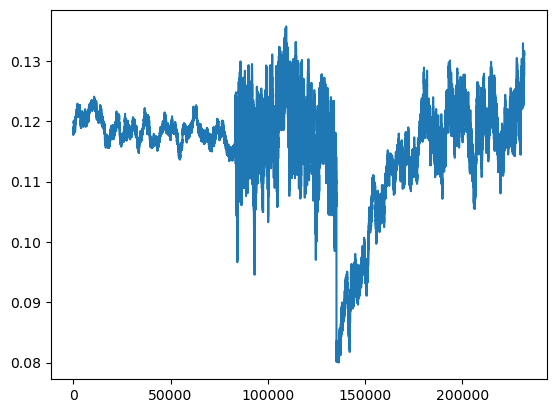

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff5abe2ed30>

In [20]:
plot(flatview(unshaped.(samples.v))[1,:])

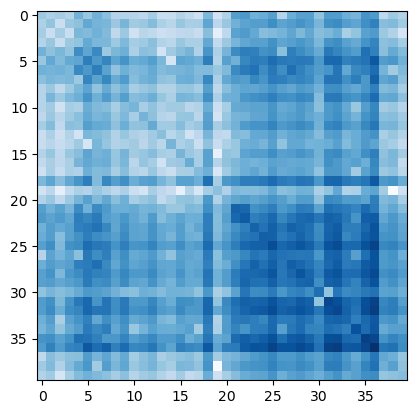

PyObject <matplotlib.image.AxesImage object at 0x7ff5abe10610>

In [21]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

In [ ]:
# BAT.bat_write("../../data/sampling_results/To_delete_3/mixture-1.hdf5", unshaped.(samples))

# BAT.bat_write("tmp.hdf5", unshaped.(samples))

In [22]:
mode(samples)[1]

(tr_size = [0.11566973593589822, 0.12499883714571852], tr_size_2 = [0.12451150840642472, 0.14376713040485206], ang_spr = [4.999694881801842, 5.755375986690965], ang_spr_2 = [2.476618232507571, 2.9989075159512084], mixt_pow = 0.7002173297061505, waist = [3.054858603038456], algmx = [36.93051804901423, 37.424495190586924, 20.22643453546742, 33.90585861286111], algmy = [31.718427398114397, 32.20406876391087, 21.240081390144244, 35.246963781973186], cam4_ped = 27.04155556747447, cam4_light_fluct = 1.3441486533298317, cam4_light_amp = 8.901192740952672, resx = [0.5249429106611875, 2.990029334838338, 0.8532599439181857], resy = [1.1065554312537513, 0.3513102059332872, 1.5387864550262391], cam4_resx = 2.9792855317693188, cam4_resy = 1.4362219740765652, psx = [26.370755030034253, 21.674287085160977, 118.23415961544416], psy = [28.26999291393984, 24.024869888564645, 128.93413037304748], cam4_psx = 97.86258486815855, cam4_psy = 103.5273306144705, light_amp = [8.464258372343794, 11.43815196992759

In [ ]:
bat_marginalmode(samples).result

In [ ]:
mean(samples)[1]

In [ ]:
std(samples)[1]

In [ ]:
dims = [1,2,3,4,5,6,7,8,9,10]
names = [1,2,3,4,5,6,7,8,9,10]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.01, 0.95, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [14,15,16,]
names = [14,15,16,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
# res

dims = [17,18,19,20,21,22,23,24]
names = [17,18,19,20,21, 22, 23, 24]
levels = [0.1, 0.5, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
#pix

dims = [25,26,27,28,29, 30, 31, 32]
names = [25,26,27,28,29, 30, 31, 32]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [33, 34, 35]
names = [33, 34, 35]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

In [ ]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

In [ ]:
params_array = [param_truth, mode(samples)[1], mean(samples)[1]]
colors_array = ["gray", "C0", "C1"]
labels_array = ["Truth", "Mode", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

## Reconstruction: 

In [ ]:
"""
    Generate simulated event for the given parameters (camera 1-3). 
"""
function generate_image_cam13(
        params::T, 
        population::Float64,
        cv_matrix::Array{Float64,2},
        light_fluctuations::Float64,
        cam_ind::Int64;
        size::Tuple{Int64, Int64}=(101,101),
        inc_noise = true,
        include_satur = true
    ) where {T <: NamedTuple}
    
    image_matrix = zeros(Float64, size...)
    
    light_coefficient = params.light_amp[cam_ind] * 10^5
    
    δ_x = params.psx[cam_ind] * 10^-3
    δ_y = params.psy[cam_ind] * 10^-3
    
    @inbounds μ_x  = params.algmx[cam_ind] * δ_x
    @inbounds μ_y  = params.algmy[cam_ind] * δ_y
    
    @inbounds σ_x_1 = sqrt.(params.tr_size[1]^2 + 10^-4*params.ang_spr[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    @inbounds σ_y_1 = sqrt.(params.tr_size[2]^2 + 10^-4*params.ang_spr[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    
    σ_x_1_res = sqrt(σ_x_1^2 + (params.resx[cam_ind]*δ_x)^2)
    σ_y_1_res = sqrt(σ_y_1^2 + (params.resy[cam_ind]*δ_y)^2) 
    
    @inbounds σ_x_2 = sqrt.(params.tr_size_2[1]^2 + 10^-4*params.ang_spr_2[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    @inbounds σ_y_2 = sqrt.(params.tr_size_2[2]^2 + 10^-4*params.ang_spr_2[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    
    σ_x_2_res = sqrt(σ_x_2^2 + (params.resx[cam_ind]*δ_x)^2)
    σ_y_2_res = sqrt(σ_y_2^2 + (params.resy[cam_ind]*δ_y)^2) 
    
#     dist_x = MixtureModel(Normal[Normal(μ_x, σ_x_1_res), Normal(μ_x, σ_x_2_res)], [params.mixt_pow, 1-params.mixt_pow])
#     dist_y = MixtureModel(Normal[Normal(μ_y, σ_y_1_res), Normal(μ_y, σ_y_2_res)], [params.mixt_pow, 1-params.mixt_pow])
    
    dist_1_x = Normal(μ_x, σ_x_1_res)
    dist_1_y = Normal(μ_y, σ_y_1_res)
    
    dist_2_x = Normal(μ_x, σ_x_2_res)
    dist_2_y = Normal(μ_y, σ_y_2_res)
    
    
    for pix_ind in CartesianIndices(image_matrix)
    
        @inbounds x_edge = pix_ind.I[1] * δ_x
        @inbounds y_edge = pix_ind.I[2] * δ_y

#                 pix_prediction = cdf(dist_x, x_edge) - cdf(dist_x, x_edge - δ_x)
#                 pix_prediction *= cdf(dist_y, y_edge) - cdf(dist_y, y_edge - δ_y)

        right_tmp, left_tmp = pdf(dist_1_x, x_edge), pdf(dist_1_x, x_edge - δ_x)
        pix_prediction_1 = (left_tmp + 0.5*(right_tmp - left_tmp))*δ_x
        right_tmp, left_tmp = pdf(dist_1_y, y_edge), pdf(dist_1_y, y_edge - δ_y)
        pix_prediction_1 *= (left_tmp + 0.5*(right_tmp - left_tmp))*δ_y

        right_tmp, left_tmp = pdf(dist_2_x, x_edge), pdf(dist_2_x, x_edge - δ_x)
        pix_prediction_2 = (left_tmp + 0.5*(right_tmp - left_tmp))*δ_x
        right_tmp, left_tmp = pdf(dist_2_y, y_edge), pdf(dist_2_y, y_edge - δ_y)
        pix_prediction_2 *= (left_tmp + 0.5*(right_tmp - left_tmp))*δ_y

        pix_prediction = params.mixt_pow*pix_prediction_1 + (1-params.mixt_pow)*pix_prediction_2
        pix_prediction = pix_prediction*light_coefficient
        
        image_matrix[pix_ind] = round(Int64, pix_prediction)
    end

    return image_matrix
end

"""
    Generate simulated event for the given parameters (camera 4). 
"""
function generate_image_cam4(
        params::T, 
        population::Float64,
        cam_ind::Int64;
        size::Tuple{Int64, Int64}=(101,101),
        inc_noise = true,
        include_satur = true
    ) where {T <: NamedTuple}
    
    image_matrix = zeros(Float64, size...)
    
    light_coefficient = params.cam4_light_amp * 10^5
    
    δ_x = params.cam4_psx * 10^-3
    δ_y = params.cam4_psy * 10^-3
    
    @inbounds μ_x  = params.algmx[cam_ind] * δ_x
    @inbounds μ_y  = params.algmy[cam_ind] * δ_y
    
    @inbounds σ_x_1 = sqrt.(params.tr_size[1]^2 + 10^-4*params.ang_spr[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    @inbounds σ_y_1 = sqrt.(params.tr_size[2]^2 + 10^-4*params.ang_spr[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    
    σ_x_1_res = sqrt(σ_x_1^2 + (params.cam4_resx*δ_x)^2)
    σ_y_1_res = sqrt(σ_y_1^2 + (params.cam4_resy*δ_y)^2) 
    
    @inbounds σ_x_2 = sqrt.(params.tr_size_2[1]^2 + 10^-4*params.ang_spr_2[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    @inbounds σ_y_2 = sqrt.(params.tr_size_2[2]^2 + 10^-4*params.ang_spr_2[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    
    σ_x_2_res = sqrt(σ_x_2^2 + (params.cam4_resx*δ_x)^2)
    σ_y_2_res = sqrt(σ_y_2^2 + (params.cam4_resy*δ_y)^2) 
    
#     dist_x = MixtureModel(Normal[Normal(μ_x, σ_x_1_res), Normal(μ_x, σ_x_2_res)], [params.mixt_pow, 1-params.mixt_pow])
#     dist_y = MixtureModel(Normal[Normal(μ_y, σ_y_1_res), Normal(μ_y, σ_y_2_res)], [params.mixt_pow, 1-params.mixt_pow])
    
    dist_1_x = Normal(μ_x, σ_x_1_res)
    dist_1_y = Normal(μ_y, σ_y_1_res)
    
    dist_2_x = Normal(μ_x, σ_x_2_res)
    dist_2_y = Normal(μ_y, σ_y_2_res)
    
    for pix_ind in CartesianIndices(image_matrix)
    
        @inbounds x_edge = pix_ind.I[1] * δ_x
        @inbounds y_edge = pix_ind.I[2] * δ_y

#                 pix_prediction = cdf(dist_x, x_edge) - cdf(dist_x, x_edge - δ_x)
#                 pix_prediction *= cdf(dist_y, y_edge) - cdf(dist_y, y_edge - δ_y)

        right_tmp, left_tmp = pdf(dist_1_x, x_edge), pdf(dist_1_x, x_edge - δ_x)
        pix_prediction_1 = (left_tmp + 0.5*(right_tmp - left_tmp))*δ_x
        right_tmp, left_tmp = pdf(dist_1_y, y_edge), pdf(dist_1_y, y_edge - δ_y)
        pix_prediction_1 *= (left_tmp + 0.5*(right_tmp - left_tmp))*δ_y

        right_tmp, left_tmp = pdf(dist_2_x, x_edge), pdf(dist_2_x, x_edge - δ_x)
        pix_prediction_2 = (left_tmp + 0.5*(right_tmp - left_tmp))*δ_x
        right_tmp, left_tmp = pdf(dist_2_y, y_edge), pdf(dist_2_y, y_edge - δ_y)
        pix_prediction_2 *= (left_tmp + 0.5*(right_tmp - left_tmp))*δ_y

        pix_prediction = params.mixt_pow*pix_prediction_1 + (1-params.mixt_pow)*pix_prediction_2
        pix_prediction = pix_prediction*light_coefficient + params.cam4_ped
        
        
        image_matrix[pix_ind] = round(Int64, pix_prediction)
    end

    return image_matrix
end


"""
    Generate simulated event using 4 cameras. 
"""
function generate_event(
        params::D, population::Float64, conv_mat::T; 
        inc_noise=true,
        size = [(70, 70),(70, 70),(40, 40),(70, 70)],
        light_fluctuations = 2.0,
        include_satur = true,
    ) where {T<: NamedTuple, D <: NamedTuple}

    
    img_1 = generate_image_cam13(params, population, conv_mat.cam_1, light_fluctuations, 1, size = size[1], inc_noise=inc_noise, include_satur=include_satur)
    img_2 = generate_image_cam13(params, population, conv_mat.cam_2, light_fluctuations, 2, size = size[2], inc_noise=inc_noise, include_satur=include_satur)
    img_3 = generate_image_cam13(params, population, conv_mat.cam_3, light_fluctuations, 3, size = size[3], inc_noise=inc_noise, include_satur=include_satur)
    img_4 = generate_image_cam4(params, population, 4, size = size[4], inc_noise=inc_noise, include_satur=include_satur)
    
    return (cam_1 = img_1, cam_2 = img_2, cam_3 = img_3, cam_4 = img_4, population = population)
end


In [ ]:
"""
    Plot integral of signal and model prediction.  
"""
function plot_cam_integral(params_array, data, conv_mat; 
        colors = ["C0", "C1", "C2"],
        labels=["1", "2", "3"],
        light_fluctuations = 2.0,
        include_satur = false,
        figsize=(8,7)
        ) 
    
    fig, ax = plt.subplots(4,2, figsize=figsize)
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    [ax[i].set_xticks([]) for i in 1:8]
    [ax[i,2].set_yticks([]) for i in 1:4]
    
    
    for cam_ind in 1:4
        
        x_axis = 1:length(data[cam_ind][1,:])
        y_axis = 1:length(data[cam_ind][:,1])
              
        ax[cam_ind, 1].fill_between(x_axis, [sum(data[cam_ind], dims=1)...], color="gray", alpha=0.5, linewidth=0, label="Data")
        ax[cam_ind, 2].fill_between(y_axis, [sum(data[cam_ind], dims=2)...], color="gray", alpha=0.5, linewidth=0)
    
    end
    
    for (ind, params) in enumerate(params_array)
        
        simulated_data = generate_event(params, data.population, conv_mat; inc_noise=false, size=[size(data.cam_1), size(data.cam_2), size(data.cam_3), size(data.cam_4)], include_satur=include_satur)
        
        for cam_ind in 1:4
            x_ind = round(Int64, params.algmx[cam_ind])
            y_ind = round(Int64, params.algmy[cam_ind])
            
            x_axis = 1:length(simulated_data[cam_ind][x_ind,:])
            y_axis = 1:length(simulated_data[cam_ind][:,y_ind])
            
            if ind == 1 
                ax[cam_ind, 1].plot(x_axis, [sum(simulated_data[cam_ind], dims=1)...], color=colors[ind], alpha=1, linewidth=1.5, label=labels[ind])
                ax[cam_ind, 2].plot(y_axis, [sum(simulated_data[cam_ind], dims=2)...], color=colors[ind], alpha=1, linewidth=1.5)
            else
                ax[cam_ind, 1].plot(x_axis, [sum(simulated_data[cam_ind], dims=1)...], label=labels[ind], color=colors[ind])
                ax[cam_ind, 2].plot(y_axis, [sum(simulated_data[cam_ind], dims=2)...], color=colors[ind])
                
            end
        end
        
    end
    
    ax[1].legend(loc="upper left")
    ax[4,1].set_xlabel(L"x")
    ax[4,2].set_xlabel(L"y")
    
    fig.text(0.04, 0.5, "Pixel Value", va="center", rotation="vertical")

end

In [ ]:
params_array

In [ ]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

In [ ]:
function eval_conv(conv_matrix, ind)
    ind = convert.(Int64, ind)
    y_tmp = exp.(conv_matrix[:, ind[1]+1])
    for ind_tmp in ind[2:end]
        y_tmp = conv(y_tmp, exp.(conv_matrix[:, ind_tmp+1]))
    end
    prepend!(y_tmp, repeat([0], length(ind)-1))
end

function eval_quantile(conv_matrix, ind; alpha_min = 0.025, alpha_max = 0.975)
    vals = eval_conv(conv_matrix, ind)
    vals_up = argmin(abs.(cumsum(vals) .- alpha_max)) 
    vals_down = argmin(abs.(cumsum(vals) .- alpha_min))
    return (vals_down, vals_up)
end

function eval_conv_is(ind, lf)
    mue = sum(ind)
    sigma = sqrt(sum((lf .* sqrt.(ind)).^2))
    return truncated(Normal(mue, sigma), 0, Inf)
end

nansum(x) = sum(x[.!isnan.(x)])

function plot_projections(cv_matrix, event_tr, event_nt, params)
    
    amp_coeff = 1.15
    alpha_1 = 0.025
    alpha_2 = 0.975
    
    median_event = generate_event(params, 
        event_nt.population, cv_matrix; 
        inc_noise=false, 
        size=[size(event_nt.cam_1), size(event_nt.cam_2), size(event_nt.cam_3), size(event_nt.cam_4)], 
        include_satur=false
    )
    
    fig, ax = plt.subplots(4,2, figsize=(12,8))
    fig.subplots_adjust(hspace=0.23, wspace=0.05)
    
    for i in 1:4 
        ycounts_nt = [sum(event_nt[i], dims=1)...]
        ycounts_tr = [sum(event_tr[i], dims=1)...]
        median_sum = [sum(median_event[i], dims=1)...]

        xedges = 1:length(ycounts_tr)

        ax[i,1].step(xedges, ycounts_nt, color="darkgray", where="mid", zorder=0)
        ax[i,1].fill_between(xedges, ycounts_tr, step="mid", color="darkgray", alpha=1)

        if i != 4
            fluct = [eval_quantile(conv_matrices[i], j, alpha_min = alpha_1, alpha_max = alpha_2) for j in eachcol(median_event[i])]
            fluct_up = [j[1] for j in fluct] .- median_sum
            fluct_down = median_sum .- [j[2] for j in fluct] 
        else
            fluct = [eval_conv_is(j, params.cam4_light_fluct) for j in eachcol(median_event[i])];
            fluct_up = [quantile(j, 0.975) for j in fluct] .- median_sum
            fluct_down = median_sum .- [quantile(j, 0.025) for j in fluct]
        end

        ax[i,1].errorbar(xedges, median_sum, yerr=[fluct_down, fluct_up], ms=2.2, fmt=".", color="darkblue", ecolor="red",  capthick=0.5, capsize=1.5, linewidth=0.5)

        ax[i,1].set_ylim(0, amp_coeff*maximum(ycounts_nt))
        ax[i,1].set_xlim(minimum(xedges), maximum(xedges))

        ycounts_nt = [sum(event_nt[i], dims=2)...]
        ycounts_tr = [sum(event_tr[i], dims=2)...]
        median_sum = [sum(median_event[i], dims=2)...]

        xedges = 1:length(ycounts_tr)

        ax[i,2].step(xedges, ycounts_nt, color="darkgray", where="mid", zorder=0)
        ax[i,2].fill_between(xedges, ycounts_tr, step="mid", color="darkgray", alpha=1)

        if i != 4
            fluct = [eval_quantile(conv_matrices[i], j, alpha_min = alpha_1, alpha_max = alpha_2) for j in eachrow(median_event[i])]
            fluct_up = [j[1] for j in fluct] .- median_sum
            fluct_down = median_sum .- [j[2] for j in fluct] 
        else
            fluct = [eval_conv_is(j, params.cam4_light_fluct) for j in eachrow(median_event[i])];
            fluct_up = [quantile(j, 0.975) for j in fluct] .- median_sum
            fluct_down = median_sum .- [quantile(j, 0.025) for j in fluct];
        end

        ax[i,2].errorbar(xedges, median_sum, yerr=[fluct_down, fluct_up], ms=2.2, fmt=".", color="darkblue", ecolor="red",  capthick=0.5, capsize=1.5, linewidth=0.5)

        ax[i,2].set_ylim(0, amp_coeff*maximum(ycounts_nt))
        ax[i,2].set_xlim(minimum(xedges), maximum(xedges))

        ax[i,1].set_yticks([])
        ax[i,2].set_yticks([])
    end

    ax[4,1].set_xlabel("x [pixel index]")
    ax[4,2].set_xlabel("y [pixel index]")

    ax[1,1].set_ylabel("Cam. #1")
    ax[2,1].set_ylabel("Cam. #2")
    ax[3,1].set_ylabel("Cam. #3")
    ax[4,1].set_ylabel("Cam. #4")

    fig.text(0.08, 0.5, "Integrated Light Intensity [a.u.]", va="center", rotation="vertical")
end

In [ ]:
images = load("../../data/experiment/dataset_2/m2/images.jld2");
event_number = 2

# Large Charge: Ev_2_2 = 2, Ev_2_1 = 311, Ev_2_3 = 440

event_nt = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);


In [ ]:
par_plot = mode(samples)[1]

In [ ]:
# par_plot = (
#     tr_size = [0.12439824118592577, 0.13354730834313178], 
#     ang_spr = [4.719652647691332, 5.273173598298776], 
#     ang_spr_2 = [1.7127605620178094, 1.7665382903788855], 
#     mixt_pow = 0.99914472220630905014, 
#     waist = [2.9349438790647464], 
#     algmx = [36.90433720235585, 37.420221571084205, 20.19493762837294, 33.86553913438116], 
#     algmy = [31.740305036014266, 32.207606923239496, 21.21978726398488, 35.25700066500729], 
#     cam4_ped = 32.20435742676351, 
#     cam4_light_fluct = 1.884619557412979, 
#     cam4_light_amp = 8.503293974136279, 
#     resx = [1.11571749301601, 3.160719027460957, 0.9591814116493919], 
#     resy = [2.596600229184074, 0.8921957823769567, 0.5845624315510309], 
#     cam4_resx = 4.58995463390224, 
#     cam4_resy = 3.1211733515253925, 
#     psx = [26.061982137021705, 22.243172122225054, 117.29172669884265], 
#     psy = [28.95142976132596, 23.990505964180528, 125.32501356858413], 
#     cam4_psx = 106.99408650796086, 
#     cam4_psy = 119.16640156374451, 
#     light_amp = [8.40717055425715, 11.412432759829358, 2.649391250442421], 
#     s_cam = [0.0, 1.478, 15.026, 23.115]
# )

In [ ]:
plot_projections(conv_matrices, event, event_nt, par_plot)

In [ ]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [par_plot, ]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)